<a href="https://colab.research.google.com/github/vasantha-krishnan/Image_Classification/blob/main/Image_Classification_for_Cats_and_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Image classification for Cats and Dogs using Pretrained Model

In [4]:
# Check if TensorFlow is installed
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

# Enable GPU acceleration if available
device_name = tf.test.gpu_device_name()
if device_name:
    print(f"GPU found: {device_name}")
else:
    print("No GPU found. Using CPU.")

# Import necessary libraries
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np


TensorFlow version: 2.17.1
No GPU found. Using CPU.


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.T18K5R_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Number of classes: 2
Training samples: 18610
Validation samples: 4652


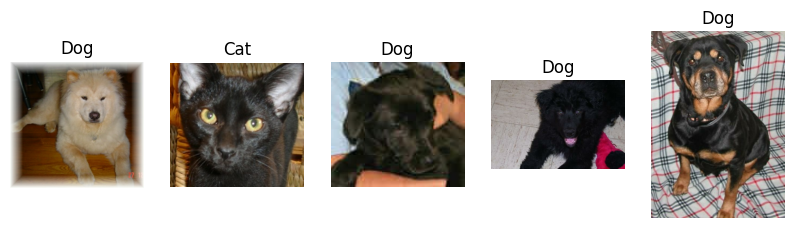

In [6]:
# Load the Cats vs Dogs dataset
(ds_train, ds_validation), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

# Get dataset information
num_classes = ds_info.features['label'].num_classes
print(f"Number of classes: {num_classes}")
print(f"Training samples: {tf.data.experimental.cardinality(ds_train).numpy()}")
print(f"Validation samples: {tf.data.experimental.cardinality(ds_validation).numpy()}")

# Function to display sample images
def show_samples(dataset, num=5):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(dataset.take(num)):
        ax = plt.subplot(1, num, i + 1)
        plt.imshow(image.numpy())
        plt.title("Cat" if label.numpy() == 0 else "Dog")
        plt.axis("off")
    plt.show()

# Display some sample images
show_samples(ds_train)


In [7]:
# Define image size and batch size
IMG_SIZE = 160  # MobileNetV2 expects 160x160 images
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Function to preprocess images
def preprocess(image, label):
    # Resize images
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    # Normalize images to [0,1]
    image = image / 255.0
    return image, label

# Apply preprocessing and prepare datasets
train_ds = ds_train.map(preprocess, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)

validation_ds = ds_validation.map(preprocess, num_parallel_calls=AUTOTUNE)
validation_ds = validation_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)


In [8]:
# Load the pre-trained MobileNetV2 model, excluding the top classification layers
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze the base model

# Add custom classification layers on top of the base model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),  # Regularization
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Display the model architecture
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
# Compile the model with appropriate loss function and optimizer
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)


In [12]:
# Define callbacks (optional)
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='cats_vs_dogs_model.weights.h5',  # Use .weights.h5 for weights-only saving
        save_weights_only=True,  # Indicate saving weights only
        save_best_only=True,  # Save the best weights
        monitor='val_accuracy',
        mode='max'
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True
    )
]

# Train the model
EPOCHS = 10
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=validation_ds,
    callbacks=callbacks
)


Epoch 1/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 517s 876ms/step - accuracy: 0.9262 - loss: 0.1717 - val_accuracy: 0.9789 - val_loss: 0.0615
Epoch 2/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 566s 883ms/step - accuracy: 0.9766 - loss: 0.0661 - val_accuracy: 0.9796 - val_loss: 0.0589
Epoch 3/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 486s 834ms/step - accuracy: 0.9789 - loss: 0.0585 - val_accuracy: 0.9817 - val_loss: 0.0575
Epoch 4/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 485s 831ms/step - accuracy: 0.9814 - loss: 0.0544 - val_accuracy: 0.9800 - val_loss: 0.0578
Epoch 5/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 483s 828ms/step - accuracy: 0.9808 - loss: 0.0523 - val_accuracy: 0.9804 - val_loss: 0.0560
Epoch 6/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 485s 832ms/step - accuracy: 0.9815 - loss: 0.0519 - val_accuracy: 0.9813 - val_loss: 0.0567


In [13]:
# Evaluate the model on the validation set
loss, accuracy = model.evaluate(validation_ds)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

146/146 ━━━━━━━━━━━━━━━━━━━━ 97s 661ms/step - accuracy: 0.9857 - loss: 0.0487
Validation Loss: 0.0575
Validation Accuracy: 0.9817


{'accuracy': [0.9592692255973816, 0.9761955738067627, 0.978237509727478, 0.9801182150840759, 0.9801719784736633, 0.9799032807350159], 'loss': [0.10525787621736526, 0.06566861271858215, 0.060377754271030426, 0.05474819242954254, 0.0528709813952446, 0.05396765097975731], 'val_accuracy': [0.9789338111877441, 0.9795786738395691, 0.9817283153533936, 0.980008602142334, 0.9804385304450989, 0.9812983870506287], 'val_loss': [0.06149454787373543, 0.05885325372219086, 0.05749388411641121, 0.0577511265873909, 0.05601231008768082, 0.05665452033281326]}


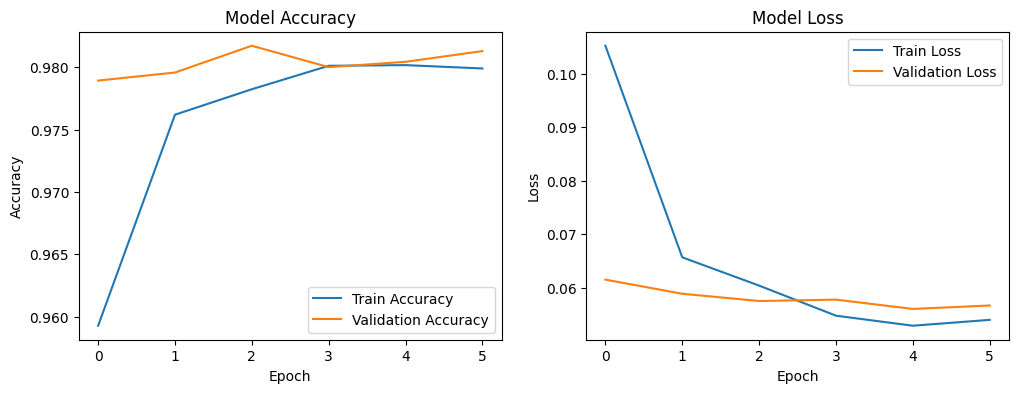

In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
print(history.history)
plt.show()

In [15]:
def predict_image(image_path):
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(
        image_path, target_size=(IMG_SIZE, IMG_SIZE)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    img_array /= 255.0  # Normalize to [0, 1]

    # Make predictions
    predictions = model.predict(img_array)
    score = predictions[0][0]

    # Display the image
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')  # Remove axes for better visibility

    # Show prediction result
    if score > 0.5:
        plt.title(f"Dog ({score*100:.2f}% confidence)", fontsize=14)
    else:
        plt.title(f"Cat ({(1 - score)*100:.2f}% confidence)", fontsize=14)

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


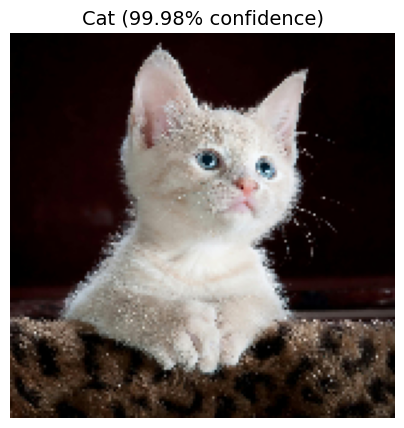

In [16]:
#predicting a image
predict_image('/content/kitty-cat-kitten-pet-45201.jpeg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


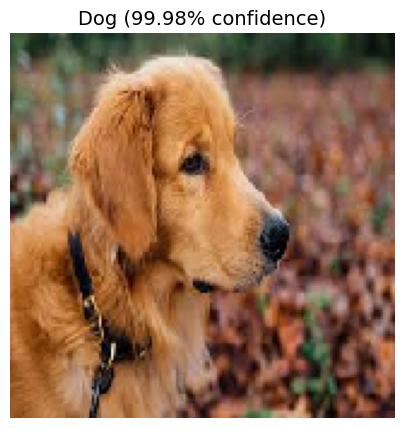

In [19]:
#Predicting a image
predict_image('/content/dog.jpeg')